## Feature selection based on "****average feature importance****" to reduce computational cost

#### In this study, we extracted a subset comprising **20% of the CICIDS2017 database**. The objective was to assess the performance of the intrusion detection system in identifying and categorizing specific attack types. This study facilitated an evaluation of how various feature selection algorithms impact the accuracy and effectiveness of detecting each attack category.

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

### Read the sampled CICIDS2017 dataset

In [3]:
df = pd.read_csv('./data/CICIDS2017_20Percent.csv')

In [4]:
df

,DestinationPort,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,538750,3,6,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS
1,53580,74,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
2,53,33686,2,2,64,248,32,32,32.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
3,80,5313019,3,1,12,0,6,0,4.000000,3.464102,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
4,53,23299,1,1,49,114,49,49,49.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566140,53,70529545,2,2,90,106,52,38,45.000000,9.899495,...,20,30619.0,0.0,30619,30619,70097803.0,0.0,70097803,70097803,Normaltraffic
566141,53,500572,2,2,95,180,48,47,47.500000,0.707107,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
566142,80,85190068,6,7,722,11595,355,0,120.333333,181.791822,...,20,3998.0,0.0,3998,3998,84800000.0,0.0,84800000,84800000,DoSHulk
566143,53,40708,1,1,43,59,43,43,43.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic


In [5]:
df.Label.value_counts()

Normaltraffic            454619
DoSHulk                   46216
PortScan                  31786
DDoS                      25596
DoSGoldenEye               2060
FTPPatator                 1588
SSHPatator                 1179
DoSslowloris               1160
DoSSlowhttptest            1101
Bot                         393
WebAttackBruteForce         301
WebAttackXSS                132
Infiltration                  7
WebAttackSqlInjection         4
Heartbleed                    3
Name: Label, dtype: int64

In [6]:
import pandas as pd

# Define the mapping of old class names to new class names
class_mapping = {
    'DDoS': 'DoS',
    'DoSGoldenEye': 'DoS',
    'DoSHulk': 'DoS',
    'DoSslowloris': 'DoS',
    'DoSSlowhttptest': 'DoS',
    'Heartbleed': 'DoS',
    'FTPPatator': 'BruteForce',
    'SSHPatator': 'BruteForce',
    'WebAttackBruteForce': 'WebAttack',
    'WebAttackXSS': 'WebAttack',
    'WebAttackSqlInjection': 'WebAttack'
}

# Replace the old class names with the new class names
df['Label'] = df['Label'].replace(class_mapping)

# Save the updated DataFrame to a new CSV file
df.to_csv('./data/CICIDS2017_20Percent.csv', index=False)


In [3]:
df = pd.read_csv('./data/CICIDS2017_20Percent.csv')

In [4]:
df.Label.value_counts()

Normaltraffic    454619
DoS               76136
PortScan          31786
BruteForce         2767
WebAttack           437
Bot                 393
Infiltration          7
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [5]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [6]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [7]:
X_train.shape

(452916, 77)

In [8]:
pd.Series(y_train).value_counts()

4    363695
2     60909
5     25429
1      2213
6       350
0       314
3         6
dtype: int64

**Corresponding Attack Types:**  
0 Bot     
1 BruteForce       
2 DoS            
3 Infiltration           
4 Normaltraffic               
5 PortScan                   
6 WebAttack          



## Machine learning model training
### Training four base learners: decision tree, random forest, extra trees, XGBoost

### Decision tree training and prediction

Accuracy of DT: 0.9957431400083018
Precision of DT: 0.9957389421895797
Recall of DT: 0.9957431400083018
F1-score of DT: 0.9957402251401943
              precision    recall  f1-score   support

         Bot       0.95      0.96      0.96        79
  BruteForce       1.00      1.00      1.00       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      0.97      0.97      6357
   WebAttack       0.90      0.94      0.92        87

    accuracy                           1.00    113229
   macro avg       0.83      0.84      0.83    113229
weighted avg       1.00      1.00      1.00    113229



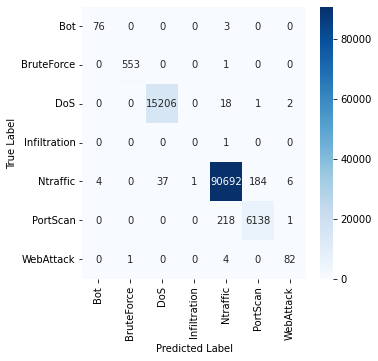

In [9]:
# Fit the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Evaluate the model
dt_score = dt.score(X_test, y_test)
y_predict = dt.predict(X_test)
y_true = y_test
print('Accuracy of DT: ' + str(dt_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [10]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

### Random Forest training and prediction

Accuracy of RF: 0.9966439693011507
Precision of RF: 0.996679214348764
Recall of RF: 0.9966439693011507
F1-score of RF: 0.9966424084528991
              precision    recall  f1-score   support

         Bot       1.00      0.85      0.92        79
  BruteForce       1.00      1.00      1.00       554
         DoS       1.00      0.99      0.99     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.96      0.90      0.93        87

    accuracy                           1.00    113229
   macro avg       0.85      0.82      0.83    113229
weighted avg       1.00      1.00      1.00    113229



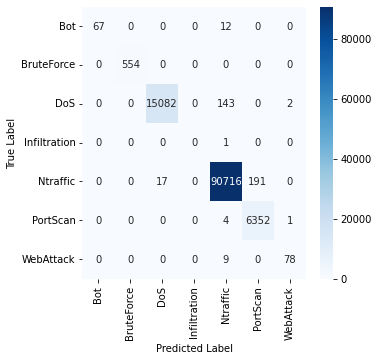

In [11]:
# Fit the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate the model
rf_score = rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
y_true = y_test
print('Accuracy of RF: ' + str(rf_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [12]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

### Extra trees training and prediction

Accuracy of ET: 0.9956724867304313
Precision of ET: 0.9956572888980137
Recall of ET: 0.9956724867304313
F1-score of ET: 0.995656572791198
              precision    recall  f1-score   support

         Bot       0.98      0.78      0.87        79
  BruteForce       0.99      1.00      1.00       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      0.97      0.97      6357
   WebAttack       0.95      0.91      0.93        87

    accuracy                           1.00    113229
   macro avg       0.84      0.81      0.82    113229
weighted avg       1.00      1.00      1.00    113229



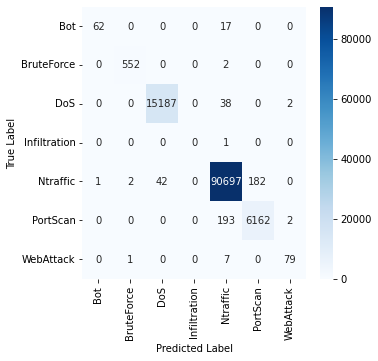

In [13]:
# Fit the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=0)
et.fit(X_train, y_train)

# Evaluate the model
et_score = et.score(X_test, y_test)
y_predict = et.predict(X_test)
y_true = y_test
print('Accuracy of ET: ' + str(et_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [14]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

### XGboost training and prediction

Accuracy of XGBoost: 0.9963260295507335
Precision of XGBoost: 0.9963571038445806
Recall of XGBoost: 0.9963260295507335
F1-score of XGBoost: 0.9963254570027039
              precision    recall  f1-score   support

         Bot       1.00      0.90      0.95        79
  BruteForce       1.00      1.00      1.00       554
         DoS       1.00      0.99      0.99     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.95      0.86      0.90        87

    accuracy                           1.00    113229
   macro avg       0.84      0.82      0.83    113229
weighted avg       1.00      1.00      1.00    113229



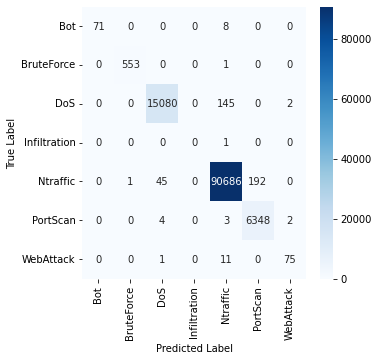

In [15]:
# Fit the XGBoost classifier
xg = xgb.XGBClassifier(n_estimators=10)
xg.fit(X_train, y_train)

# Evaluate the model
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test
print('Accuracy of XGBoost: ' + str(xg_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))

# Print the classification report
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap
cm = confusion_matrix(y_true, y_predict)

# Rename the class labels in the confusion matrix
cm_renamed = cm.copy()
for i in range(len(target_names)):
    for j in range(len(target_names)):
        cm_renamed[i][j] = cm[target_names.index(target_names[i])][target_names.index(target_names[j])]

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_renamed, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [16]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [17]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,5,5,5,5
4,4,4,4,4


In [18]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [19]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9957519716680355
Precision of Stacking: 0.9957389912265113
Recall of Stacking: 0.9957519716680355
F1-score of Stacking: 0.9957446601435486
              precision    recall  f1-score   support

         Bot       0.95      0.96      0.96        79
  BruteForce       1.00      1.00      1.00       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      0.97      0.97      6357
   WebAttack       0.90      0.94      0.92        87

    accuracy                           1.00    113229
   macro avg       0.83      0.84      0.83    113229
weighted avg       1.00      1.00      1.00    113229



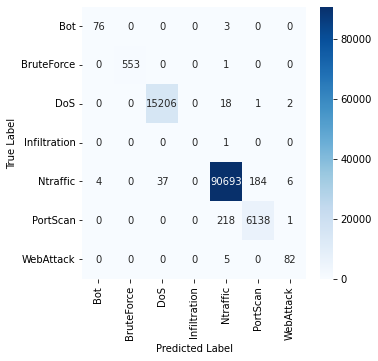

Execution Time: 40.350104570388794 seconds


In [22]:
import time

# Record the starting time
start_time = time.time()

# Your code here
# Fit the XGBClassifier for stacking
stk = xgb.XGBClassifier().fit(x_train, y_train)

# Make predictions and evaluate the model
y_predict = stk.predict(x_test)
y_true = y_test
stk_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: ' + str(stk_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: ' + str(precision))
print('Recall of Stacking: ' + str(recall))
print('F1-score of Stacking: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")


## Feature Selection

### Feature importance

In [23]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [24]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [25]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.2182, 'Bwd_Packet_Length_Std'), (0.0842, 'Average_Packet_Size'), (0.0626, 'Min_Packet_Length'), (0.0461, 'PSH_Flag_Count'), (0.0454, 'Flow_Bytes_s'), (0.0437, 'DestinationPort'), (0.0341, 'Bwd_Packet_Length_Mean'), (0.0329, 'Packet_Length_Mean'), (0.0315, 'Bwd_Packets_s'), (0.0306, 'Avg_Bwd_Segment_Size'), (0.0261, 'Flow_Packets_s'), (0.0259, 'Packet_Length_Std'), (0.0222, 'Bwd_Packet_Length_Max'), (0.0211, 'Packet_Length_Variance'), (0.0181, 'Fwd_Packets_s'), (0.0179, 'Fwd_Packet_Length_Min'), (0.0151, 'Max_Packet_Length'), (0.0151, 'Init_Win_bytes_forward'), (0.0113, 'Total_Length_of_Fwd_Packets'), (0.0101, 'Bwd_Packet_Length_Min'), (0.0094, 'Fwd_IAT_Std'), (0.0092, 'ACK_Flag_Count'), (0.0091, 'Fwd_Packet_Length_Max'), (0.0087, 'Subflow_Fwd_Bytes'), (0.0082, 'Total_Backward_Packets'), (0.0081, 'Avg_Fwd_Segment_Size'), (0.0078, 'Flow_IAT_Mean'), (0.0074, 'Flow_IAT_Std'), (0.0073, 'Flow_IAT_Min'), (0.0071, 'Flow_IAT_Max'), (0.0069, 'Fwd_IAT_Max'), (0

In [26]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [27]:
len(f_list)

77

In [28]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break 

In [29]:
X_fs = df[fs].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [31]:
X_train.shape

(452916, 31)

In [32]:
pd.Series(y_train).value_counts()

4    363695
2     60909
5     25429
1      2213
6       350
0       314
3         6
dtype: int64

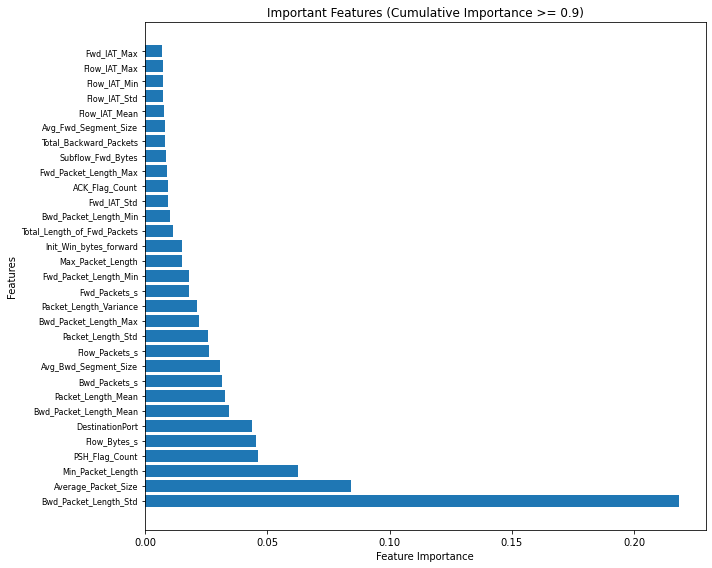

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

# Calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature) / 4

# Get the feature names
feature_names = df.drop(['Label'], axis=1).columns.values

# Sort the features based on their score
sorted_features = sorted(zip(avg_feature, feature_names), reverse=True)

# Extract the sorted scores and feature names
sorted_scores, sorted_names = zip(*sorted_features)

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_scores)

# Find the index where cumulative importance reaches 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Extract the important features
important_features = sorted_names[:index+1]
important_scores = sorted_scores[:index+1]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(important_features)), important_scores, align='center')
plt.yticks(range(len(important_features)), important_features, fontsize=8)
plt.xlabel('Feature Importance', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.title('Important Features (Cumulative Importance >= 0.9)', fontsize=12)
plt.tight_layout()  # Adjust spacing between the bars

plt.show()

In [34]:
from tabulate import tabulate

# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

# Calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature) / 4

# Get the feature names
feature_names = df.drop(['Label'], axis=1).columns.values

# Sort the features based on their score
sorted_features = sorted(zip(avg_feature, feature_names), reverse=True)

# Extract the sorted scores and feature names
sorted_scores, sorted_names = zip(*sorted_features)

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_scores)

# Find the index where cumulative importance reaches 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Extract the important features and their corresponding scores
important_features = sorted_names[:index+1]
important_scores = sorted_scores[:index+1]

# Calculate the weights for the important features
total_importance = np.sum(important_scores)
weights = important_scores / total_importance

# Create a list of lists for the table
table_data = [[feature, weight] for feature, weight in zip(important_features, weights)]

# Define the table headers
headers = ["Feature", "Weight"]

# Print the table
table = tabulate(table_data, headers, tablefmt="fancy_grid")
print(table)


╒═════════════════════════════╤════════════╕
│ Feature                     │     Weight │
╞═════════════════════════════╪════════════╡
│ Bwd_Packet_Length_Std       │ 0.242106   │
├─────────────────────────────┼────────────┤
│ Average_Packet_Size         │ 0.093357   │
├─────────────────────────────┼────────────┤
│ Min_Packet_Length           │ 0.0694167  │
├─────────────────────────────┼────────────┤
│ PSH_Flag_Count              │ 0.0511815  │
├─────────────────────────────┼────────────┤
│ Flow_Bytes_s                │ 0.0503756  │
├─────────────────────────────┼────────────┤
│ DestinationPort             │ 0.0484774  │
├─────────────────────────────┼────────────┤
│ Bwd_Packet_Length_Mean      │ 0.0378506  │
├─────────────────────────────┼────────────┤
│ Packet_Length_Mean          │ 0.0364632  │
├─────────────────────────────┼────────────┤
│ Bwd_Packets_s               │ 0.0349247  │
├─────────────────────────────┼────────────┤
│ Avg_Bwd_Segment_Size        │ 0.0339306  │
├─────────

╒═════════════════════════════╤════════════╕
│ Feature                     │     Weight │
╞═════════════════════════════╪════════════╡
│ Bwd_Packet_Length_Std       │ 0.242106   │
├─────────────────────────────┼────────────┤
│ Average_Packet_Size         │ 0.093357   │
├─────────────────────────────┼────────────┤
│ Min_Packet_Length           │ 0.0694167  │
├─────────────────────────────┼────────────┤
│ PSH_Flag_Count              │ 0.0511815  │
├─────────────────────────────┼────────────┤
│ Flow_Bytes_s                │ 0.0503756  │
├─────────────────────────────┼────────────┤
│ DestinationPort             │ 0.0484774  │
├─────────────────────────────┼────────────┤
│ Bwd_Packet_Length_Mean      │ 0.0378506  │
├─────────────────────────────┼────────────┤
│ Packet_Length_Mean          │ 0.0364632  │
├─────────────────────────────┼────────────┤
│ Bwd_Packets_s               │ 0.0349247  │
├─────────────────────────────┼────────────┤
│ Avg_Bwd_Segment_Size        │ 0.0339306  │
├─────────

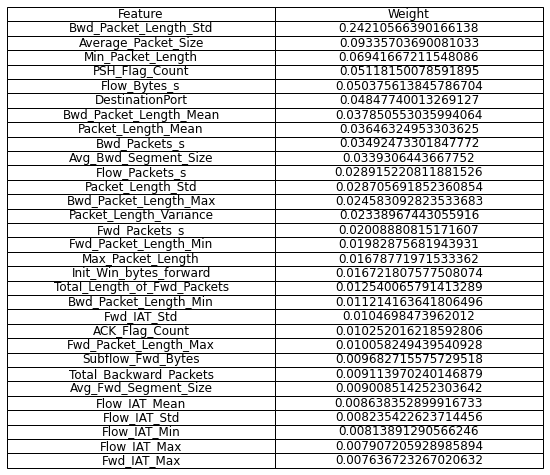

In [35]:
from tabulate import tabulate
import matplotlib.pyplot as plt

# Your code to calculate the important features and weights

# Create a list of lists for the table
table_data = [[feature, weight] for feature, weight in zip(important_features, weights)]

# Define the table headers
headers = ["Feature", "Weight"]

# Print the table
table_str = tabulate(table_data, headers, tablefmt="fancy_grid")
print(table_str)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.axis("off")

# Plot the table
table = ax.table(cellText=table_data, colLabels=headers, cellLoc="center", loc="center")

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Save the figure as a PDF
plt.savefig("table.pdf", bbox_inches="tight")

## Machine learning model training after feature selection

Accuracy of DT: 0.995398705278683
Precision of DT: 0.9953656989926842
Recall of DT: 0.995398705278683
F1-score of DT: 0.9953794624930187
              precision    recall  f1-score   support

         Bot       0.96      0.96      0.96        79
  BruteForce       0.99      1.00      0.99       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      0.96      0.97      6357
   WebAttack       0.82      0.72      0.77        87

    accuracy                           1.00    113229
   macro avg       0.82      0.81      0.81    113229
weighted avg       1.00      1.00      1.00    113229



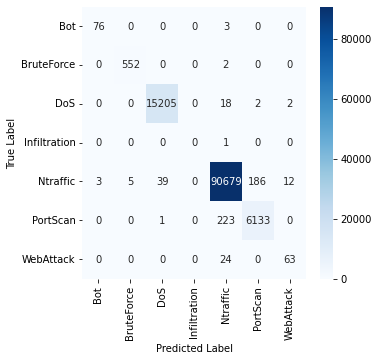

In [36]:
# Fit the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Evaluate the model
dt_score = dt.score(X_test, y_test)
y_predict = dt.predict(X_test)
y_true = y_test
print('Accuracy of DT: ' + str(dt_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [37]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9968647607944962
Precision of RF: 0.9968968216746398
Recall of RF: 0.9968647607944962
F1-score of RF: 0.9966459112060984
              precision    recall  f1-score   support

         Bot       1.00      0.91      0.95        79
  BruteForce       1.00      1.00      1.00       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      1.00      0.98      6357
   WebAttack       1.00      0.17      0.29        87

    accuracy                           1.00    113229
   macro avg       0.85      0.72      0.75    113229
weighted avg       1.00      1.00      1.00    113229



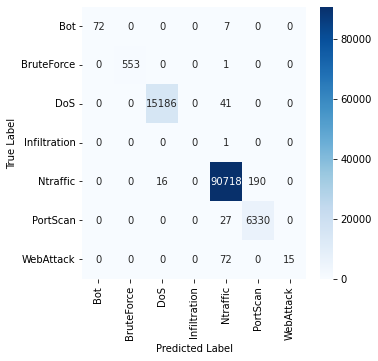

In [38]:
# Fit the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate the model
rf_score = rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
y_true = y_test
print('Accuracy of RF: ' + str(rf_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [39]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9956989817096327
Precision of ET: 0.9956768410128496
Recall of ET: 0.9956989817096327
F1-score of ET: 0.9956793481612746
              precision    recall  f1-score   support

         Bot       0.97      0.82      0.89        79
  BruteForce       0.99      1.00      1.00       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      0.97      0.97      6357
   WebAttack       0.92      0.78      0.84        87

    accuracy                           1.00    113229
   macro avg       0.84      0.80      0.81    113229
weighted avg       1.00      1.00      1.00    113229



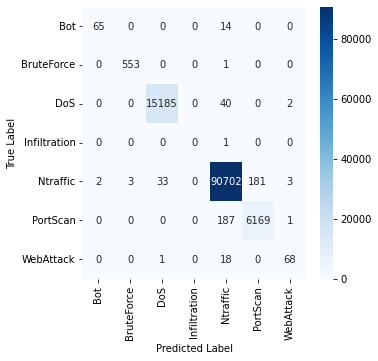

In [40]:
# Fit the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=0)
et.fit(X_train, y_train)

# Evaluate the model
et_score = et.score(X_test, y_test)
y_predict = et.predict(X_test)
y_true = y_test
print('Accuracy of ET: ' + str(et_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [41]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9952750620424097
Precision of XGBoost: 0.9951719040399425
Recall of XGBoost: 0.9952750620424097
F1-score of XGBoost: 0.995093070440588
              precision    recall  f1-score   support

         Bot       1.00      0.72      0.84        79
  BruteForce       0.98      1.00      0.99       554
         DoS       0.99      0.99      0.99     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.74      0.23      0.35        87

    accuracy                           1.00    113229
   macro avg       0.81      0.70      0.74    113229
weighted avg       1.00      1.00      1.00    113229



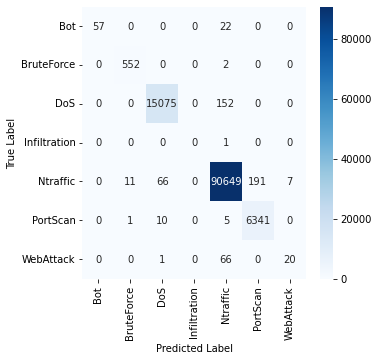

In [42]:
# Fit the XGBoost classifier
xg = xgb.XGBClassifier(n_estimators=10)
xg.fit(X_train, y_train)

# Evaluate the model
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test
print('Accuracy of XGBoost: ' + str(xg_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))

# Print the classification report
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap
cm = confusion_matrix(y_true, y_predict)

# Rename the class labels in the confusion matrix
cm_renamed = cm.copy()
for i in range(len(target_names)):
    for j in range(len(target_names)):
        cm_renamed[i][j] = cm[target_names.index(target_names[i])][target_names.index(target_names[j])]

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_renamed, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [43]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [44]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,5,5,5,5
4,4,4,4,4


In [45]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [46]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9952485670632082
Precision of Stacking: 0.995215772241815
Recall of Stacking: 0.9952485670632082
F1-score of Stacking: 0.9952257592542043
              precision    recall  f1-score   support

         Bot       1.00      0.86      0.93        79
  BruteForce       1.00      1.00      1.00       554
         DoS       1.00      1.00      1.00     15227
Infiltration       0.00      0.00      0.00         1
    Ntraffic       1.00      1.00      1.00     90924
    PortScan       0.97      0.96      0.97      6357
   WebAttack       0.82      0.72      0.77        87

    accuracy                           1.00    113229
   macro avg       0.83      0.79      0.81    113229
weighted avg       1.00      1.00      1.00    113229



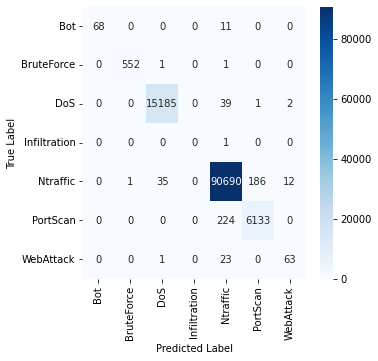

Execution Time: 38.929903507232666 seconds


In [48]:
import time

# Record the starting time
start_time = time.time()
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
#print(classification_report(y_true,y_predict))
# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()
# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")